In [2]:
%%time
NBNAME = '=RNASeq=BulkClust'
DIR = 'Clust'
execfile('header.py')
reload(util)
reload(pyutil)
pyutil.os.system('mkdir -p %s'%DIR)

[NbConvertApp] Converting notebook header.ipynb to python
[NbConvertApp] Writing 566 bytes to header.py
is in ipython: 1
CPU times: user 60 ms, sys: 44 ms, total: 104 ms
Wall time: 1.75 s


In [438]:
from countMatrix import countMatrix

In [69]:
df = pd.DataFrame(dd1.train_data)
df.reset_index?
# len(dd1.colName),len(pd.DataFrame(dd1.train_data).columns)

In [ ]:
%%writefile ~/repos/BrachyPhoton/synotil/CountMatrix.py
import numpy as np
import pandas as pd
# import util; reload(util); from util import *
import pymisca.util as pyutil
import pymisca.vis_util as pyvis
# from util import sortLabel

##### Utility functions
def sortLabel(Y,X,#return_pos=0
             ):
    ### Sorting by maximum
#         X = vX
    X  = X-X.mean(axis=1,keepdims=1)
    coord = np.arange(X.shape[-1])[None]
    wt_X = (X == X.max(axis=1,keepdims=1))*coord
#         wt_X = X * coord
    cis = list(range(max(Y)+1))
    pos =  [wt_X[Y == ci,:].mean() for ci in cis]
    sidx = np.argsort(pos)
#     if return_pos:
#         return pos[sidx]
#     else:
    pj = dict(zip(sidx,cis))
    Y = np.vectorize(pj.get)(Y)
    return Y,np.take(pos,sidx)

def addBox(dd=None,nCol=None,nRow=None,ax=None):
#     dd = self
    if dd is not None:
        nCol, nRow = dd.nCol, dd.nRow
        if dd.condCount() <= 1:
            return ax    
    if not isinstance( ax, pyutil.mpl.axes.Axes):
        ax = ax.axes        
    x = np.cumsum([0,] + list(nCol))
    for a, b in zip(x[:-1],x[1:]):
#         print a,b,nRow  ##Debug
        r = pyutil.mpl.patches.Rectangle(( -0.5, a - 0.5),
                                         nRow, b-a,
                                         fill=False,color='red')
        ax.add_artist(r)
    return ax

def predictWithCut(mdl,data,CUTOFF=0.5):
    '''Cutoff a BGM by weights of components GMMs
#### This should be added to the BGM class
'''

    W = mdl.weights_.copy()
    idx = W.argsort()[::-1]
    mdl.active = idx[:np.where((W[idx].cumsum()>CUTOFF))[0][0]+1]
    P = mdl.predict_proba(data)
    P = P[:,mdl.active]
    clu = P.argmax(axis=1)
    return clu

def fillNA_withRef(dd, ref):
    naX,naY = np.where(np.isnan(dd.train_data))
    if len(naX)==0:
        pass
    else:
        naX_mapped,naX_uniq = pyutil.reindexZero(naX)
        naY_mapped,naY_uniq = pyutil.reindexZero(naY)
        odf = ref.reindex(index=dd.index[naX_uniq],columns=dd.columns[naY_uniq])
        dd.train_data[(naX,naY)] = odf.values[(naX_mapped, naY_mapped)]
    return dd    
def wrapDFMethod(DFMethod):
    '''Wrap a pd.DataFrame method to return countMatrix instance
'''
    def newMethod(self,*args,**kwargs):
        df = DFMethod(self,*args,**kwargs)
        obj= self.setDF(df=df)
        return obj
    return newMethod

# class countMatrix(pyutil.pd.DataFrame):




class countMatrix(pd.DataFrame):
    ''' A decorated pandas.DataFrame class that
knows how to plot itself
'''
#     name = None
#     look = None
#     @property
#     def _constructor(self):
#         return countMatrix
    def __init__(self,C=None, rowName=None, colName = None,
                 name = None,
                 look = None,
                 cmap = None,
                 vlim = None,
                 fname = None,
                 model = None,
                 **kwargs):
        df = pyutil.init_DF( C=C,rowName=rowName,colName = colName)  
#         print self.__class__,countMatrix, isinstance(self,countMatrix,)
        super(countMatrix, self).__init__(df)
        self.name_ = name
        self.look = look
        self.cmap = cmap
        self.vlim = vlim
        self.fname = fname
        self.model = model
        self.param = {'normF':'identityNorm',
                     }        
        self.set_config( test=None,**kwargs)
        self.test= None
        
    @property
    def name(self):
        return str(self.name_).split('/')[-1]
    def formatName(self,name=None,**kwargs):
        name = self.name if name is None else name
        res = pyutil.formatName(name,**kwargs)
        return res
    
    def __getstate__(self):
        d = dict(self.__dict__)
#         del d['logger']
        return d
    def __setstate__(self, d):
        self.__dict__.update(d) # I *think* this is a safe way to do it
        
    def set_name(self,name):
        self.name_ = name
        return name
    def set_config(self, **kwargs):
        if 'name' in kwargs:
            self.set_name(kwargs.pop('name'))
        for k,v in kwargs.items():
#             if v is not None:
            setattr(self,k,v)        
    def get_config(self):
        config = {'name':self.name,
                 'look':self.look,
                 'cmap':self.cmap,
                 'vlim':self.vlim,
                 'model':self.model,}
        return config
    def __repr__(self, ):
        s = '<countMatrix: name=%s>'% self.name
        return s
    
    def setDF(self,df):
        config = self.get_config()
        if isinstance(df,pd.Series):
            df = df.values
        if isinstance(df, pyutil.np.ndarray):
            if df.shape == self.shape:
                self.loc[:,:] = df
                res = self
            else:
                res = pyutil.init_DF(df, rowName = self.index)
        else:
            res = df
        if not isinstance(res, self.__class__ ):
            assert isinstance( res, pd.DataFrame)
#             print self.__class__, res.__class__
            res = self.__class__.from_DataFrame(df = res,)            
            
        res.set_config(**config)
        return res


    @classmethod
    def from_DataFrame(cls,df=None,fname=None,name=None,index_col = None, **kwargs):
        if df is None:
            assert fname is not None,'[ERR] must specify one of "df" or "fname" '
            df = pyutil.readData(fname,**kwargs)
            name = pyutil.os.path.basename(fname).rsplit('.',1)[0]
        elif isinstance(df,pd.Series):
            df = df.to_frame()
        if index_col is not None:
            assert index_col in df
            df.set_index(index_col,drop=0,inplace=1)
#         print 3,type(df)
        ins = cls(C=df.values,
                 colName=df.columns,
                 rowName=df.index,
                  name=name,
                  fname=fname,
                 )
        return ins
    
    @classmethod
    def from_npy(cls,fname,**kwargs):
        dd = np.load(fname).tolist()
        ins = cls.from_dict(dd,**kwargs)
        ins.fname = fname
        return ins
    @classmethod
    def from_dict(cls,dd,**kwargs):
        C,colName,rowName = [ dd.pop(key) for key in ['train_data','colName','rowName']]
        dd.update(kwargs)
        df = cls(C=C,colName=colName,rowName=rowName,**dd)
        return df
    @classmethod
    def from_deepcache(cls, d= None, fname = None):
        if fname is not None:
            d = np.load(fname)
            d = dict(d)
        else:
            assert d is not None,'must specify one of variables: "d" or "fname"'
        deepdict = d
        C = deepdict.get('matrix',np.array([[]]))
        colName= deepdict.get('labels',None)
        rowName =deepdict.get('which is row name?',None)
        df  = pyutil.init_DF(C=C,colName=colName,rowName=rowName)
        ins = cls.from_DataFrame(df=df)
        return ins
    def colName_short(self,condName=None):
        condName = self.columns if condName is None else condName        
        try:
            condName = pyutil.meta2flat([ 
                [x[1] for x in y] 
                    for y in pyutil.flat2meta(condName)],
                seps=['_'])
        except Exception as e:
            print '\n [WARN] unable to simplify condName. Exception:%s'%e
        finally:
            return condName
    def heatmap(self,C=None,vlim=None,cname = 'test',
                reorder=0,ax=None,
                **kwargs):
        vlim = self.vlim if vlim is None else vlim
        reorder and self.reorder();
        C = self.values if C is None else C
        condName = self.colName_short()
#         im = pyvis.heatmap(C[cidx][sidx],
        im = pyvis.heatmap(C,
#                            ylab=(None if not i else 'Gene'),
#                            ytick = (None if not i else gCur['Gene Name']),
                           xlab='Condition',
                           xtick=condName,
                           transpose=1,
                           cname = cname,
                           vlim = vlim,
                          ax=ax,**kwargs
                          ) 
        
        if 0:
            addBox(dd= self,ax=im.axes)
        else:
#             print '[DEV] addBox() is disabled fodr now'
            pass
        return im
    
    

    def copy(self,deep = True):
# #         df = super(countMatrix, self).copy(deep=deep)
        df = pd.DataFrame.copy(self,deep=deep)
        dd = self.setDF(df=df)        
        return dd
    
    def qc_Avg(self):
        '''Add summary dataFrame as an attribute
    '''
        import util as sutil
        (M,SD,CV), _ = sutil.qc_Avg( self,silent=1)
        # df = pd.concat([M,SD,CV],axis=1)
        df = pd.DataFrame({'M':M,
                           'SD':SD, 
                           'CV':CV})
#         df = pd.DataFrame({'M':M.values,
#                            'SD':SD.values, 
#                            'CV':CV.values})
        df = df.set_index( self.index)
        df['per'] = pyutil.dist2ppf(df.SD)

        self.summary = df
        return self        

#     def fillna(self,fill,inplace=1,**kwargs):
#         pd.DataFrame.fillna(self,fill,inplace=inplace,**kwargs)
#         return self
#     def apply(self,*args,**kwargs):
#         df = pd.DataFrame.apply(self,*args,**kwargs)
    #### ====<
    ### ====> Wrappers for pandas.DataFrame native methods
    @wrapDFMethod
    def sortedLabel(self,clu = None,CUTOFF=None):
        C = self.values
        if clu is None:
            if CUTOFF is not None:
                clu = predictWithCut(self.model,C, CUTOFF=CUTOFF)
            else:
                clu = self.model.predict(C)
                
        clu, pos = sortLabel(clu,C)
        return pd.DataFrame(clu).set_index(self.index)

    @wrapDFMethod
    def predict(self, C= None,CUTOFF=None):
        C = self.values if C is None else C
        if CUTOFF is not None:
            clu = predictWithCut(self.model,C, CUTOFF=CUTOFF)
        else:
            clu = self.model.predict(C)
        return pd.DataFrame(clu).set_index(self.index)
    def predict_proba(self,C=None,asDF=1):        
        C = self.values if C is None else C
        if hasattr(self.model,'predict_proba'):        
            clu = self.model.predict_proba(C)
        elif hasattr(self.model,'predict'):
            clu = self.model.predict(C)
            clu = pyutil.oneHot(clu)
        if asDF:
            clu = pd.DataFrame(clu).set_index(self.index)    
        return clu
    def reorder(self):
        clu = self.sortedLabel()
        clu = clu.sort_values(0,)
        res = self.setDF( self.reindex(clu.index, ))
        return res
#     def condCount(self):
#         if isinstance(self.nCol, pyutil.collections.Iterable):
#             n = sum(1 for x in self.nCol)
#         else:
#             n = 1
#         return n    
    def sanitiseIndex(self,ptn):
        '''Apply a Regex capturer to sanitise/standardise the index
'''
        res = [x[0] for x in self.index.map(ptn.findall)]
        res = self.set_index([res],inplace=1)
        return self
    def flatSubset(self, keep,negate = 0, which = 'columns'):
        vals = getattr(self,which)
        isStr = isinstance(vals,str)
        if isStr:
            vals = [vals]
        vals = map(str,vals)
        vals = pyutil.flatSubset( vals, 
                                         keep = keep, 
                                         negate =negate)
        if isStr:
            vals =vals[0]
        setattr(self, which, vals)
        return self

countMatrix.fillNA_withRef = fillNA_withRef
countMatrix.addBox = addBox
countMatrix.mergeByIndex = wrapDFMethod(pyutil.mergeByIndex)
countMatrix.filterMatch = wrapDFMethod(pyutil.filterMatch)
countMatrix.to_tsv = pyutil.to_tsv




countMatrix.fillna= wrapDFMethod(pd.DataFrame.fillna)
countMatrix.apply = wrapDFMethod(pd.DataFrame.apply)
countMatrix.applymap = wrapDFMethod(pd.DataFrame.applymap)
countMatrix.merge = wrapDFMethod(pd.DataFrame.merge)
countMatrix.query = wrapDFMethod(pd.DataFrame.query)
countMatrix.sort_values = wrapDFMethod(pd.DataFrame.sort_values)
countMatrix.reindex = wrapDFMethod(pd.DataFrame.reindex)
countMatrix.astype = wrapDFMethod(pd.DataFrame.astype)

lst = ['clip','mean','max','min','std','dropna','get','rename']
for name in lst:
    setattr(countMatrix,name,
            wrapDFMethod( getattr( pd.DataFrame, name)) )

    
def queryBed(bedDF, qid):
    '''query a bed file with a list of accessions 
'''
    if isinstance(bedDF,str):
        bedFile = bedDF 
        bedDF = countMatrix.from_DataFrame(
            fname = bedFile,ext='tsv',header=None).reset_index()
    resDF = bedDF.set_index(3,drop=0).reindex(qid,).reset_index(drop=1)
    return resDF

# countMatrix.mergeByIndex = wrapDFMethod(pyutil.functools.partial(pd.DataFrame.merge,
#                                                    left_index=True,
#                                                    right_index=True,)
#                                        )

countMatrix.append = wrapDFMethod(pd.DataFrame.append)

def vstack(lst,how='outer', as_index=0, as_df =0, **kwargs):
#     if how = 'left':
    if as_index:
#         lst = [x.setDF( pd.DataFrame(x.index,index=x.index)) for x in lst]
#         lst = [x.setDF( x.iloc[:,:1]) for x in lst]
        lst = [x.drop( x.columns,1) for x in lst]
    res = reduce(lambda x,y :x.mergeByIndex(y,how=how,**kwargs),lst)
    
    if as_index:
        res = res.index    
    return res

def concat(*args,**kwargs):
    df = pd.concat(*args,**kwargs)
    obj= countMatrix.from_DataFrame(df=df)
    return obj


class geneList(countMatrix):
    def __init__(self,C=None,colName=None,rowName=None,**kwargs):
        super(geneList,self).__init__(C=len(rowName) * [1],rowName=rowName, **kwargs)
#         self.astype('int')
        col = self.columns[0]
        self[col]= self[col].astype(int)
        add_predictProba(self)
#         self.add_predictProba()
# geneList.        
def add_predictProba(glist):
    mdl = pyutil.util_obj()
    def f(vals):
        res = np.nan_to_num(vals).astype(int)
        res = pyutil.oneHot(res)
        return res
    mdl.predict_proba =  f
    glist.model = mdl
    return glist

        
#### Obsolete

def makeCountMatrix(arg):
    if isinstance(arg,str):
        res = countMatrix.from_npy(arg)
    elif isinstance(arg,dict):
        res = countMatrix(**arg)
    else:
        res = arg
    return res

def mergeCountMatrix(dd1,dd2,vlim=[-2,2],how='outer'):
    ''' Merge two countMatrix
    '''
    dd1 = makeCountMatrix(dd1); dd2 = makeCountMatrix(dd2) 
#     dd1 = countMatrix(dd1); dd2 = countMatrix(dd2) 
    C1,C2 = dd1.train_data, dd2.train_data
    colName = np.hstack([dd1.colName,dd2.colName])
    condName = dd1.colName_short(colName)
#     print all(sorted(dd1.rowName)==dd1.rowName)
    g1 = set(dd1.rowName); g2 = set(dd2.rowName); 
    g1Only = g1-g2; g2Only = g2-g1;  gAny = g1 | g2;    gAll = (g1 & g2)
    gAll = list(gAll)
    print 'Union:%d, Shared:%d'%(len(gAny),len(gAll))
    
    ### Find union genes
    ### Assume rowNames are sorted
    idx1 = np.in1d( dd1.rowName, gAll)
    idx2 = np.in1d( dd2.rowName, gAll)        
    r1 = dd1.rowName[idx1]; r2 = dd2.rowName[idx2]
    clu1 = dd1.sortedLabel()
    clu2 = dd2.sortedLabel()
    gAll = dd1.rowName[idx1]   
    CAll = np.hstack([C1[idx1],
                      C2[idx2],
                  ])[(clu1)[idx1].argsort()]

    ### Find C1-only genes
    idx1 = np.in1d( dd1.rowName, list(g1Only))
    gLef = dd1.rowName[idx1]
    CLef = np.hstack([ 
        C1[idx1],
        np.zeros(( sum(idx1),len(dd2.colName)) )*np.nan,
    ])[(clu1)[idx1].argsort()]    
    
    idx2 = np.in1d( dd2.rowName, list(g2Only))
    gRht = dd2.rowName[idx2]
    CRht = np.hstack([ 
        np.zeros(( sum(idx2),len(dd1.colName)) )*np.nan,
        C2[idx2],
    ])[(clu2)[idx2].argsort()]
    
    C   = np.vstack([CLef,CAll,CRht])
    gRef= np.hstack([gLef,gAll,gRht])
    
    dd = {'train_data':C,
                    'colName':colName,
                    'rowName':gRef}

    for k in ['suc', 'name', 'param', 'model','nCol']:
        v1 = getattr(dd1,k);
        v2 = getattr(dd2,k)
        if not isinstance(v1,list):
            v1 = [v1,]
        if not isinstance(v2, list):
            v2 = [v2,]
        dd[k] = v1 + v2
    
    dd = countMatrix(**dd)
    if how =='outer': 
        pass 
    elif how=='left':
        idx = np.hstack([gLef,gAll])
        dd.setDF(dd.df.loc[idx])
#         dd.df = dd.df.reindex(index = ,copy=0)
    elif how=='right':
        idx = np.hstack([gAll,gRht])
        dd.setDF(dd.df.loc[idx])
    elif how=='inner':
        idx = np.hstack([gAll])
        dd.setDF(dd.df.loc[idx])
    
    return dd

In [98]:
!ls *.png

mytable.png  test.png


In [109]:
import openpyxl
ws = openpyxl.load_workbook('main.xlsx')
st = ws.worksheets[0]
st.add_image(openpyxl.drawing.image.Image('./test.png'), 'A1')
# ws.save?
ws.save('main.xlsx')

In [94]:

# import pillow

ImportError: No module named pillow

In [ ]:
pd.Index.todd

In [48]:
d1 = {'name': None }
d2 = {'name':'left'}
map(pyutil.dict2flat,[d1,d2])

['name=None', 'name=left']

In [39]:
import pymisca.util as pyutil
pyutil.dict2flat({'hi':1})

'hi=1'

In [37]:
import pandas as pd
pd.DataFrame.merge?

is in ipython: 1


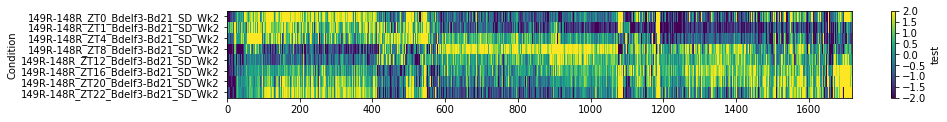

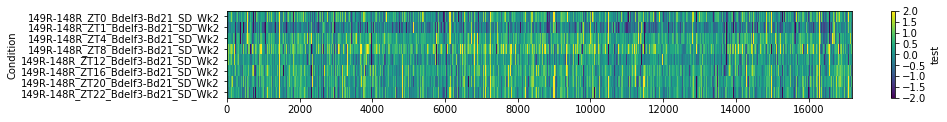

In [207]:
import countMatrix as cm; reload(cm)
reload(pyutil)
dd = cm.countMatrix.from_npy(fname='./Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy')
dd.heatmap(reorder=1)
dd = cm.countMatrix.from_DFrame(fname='./MatPrep/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk')
dd.heatmap()

In [ ]:
# df.

In [155]:
df.reindex?

In [86]:
dd1.__dict__

{'colName': Index([u'RunID=149R-148R_ZTime=ZT0_gtype=Bdelf3-Bd21_light=SD_Age=Wk2',
        u'RunID=149R-148R_ZTime=ZT1_gtype=Bdelf3-Bd21_light=SD_Age=Wk2',
        u'RunID=149R-148R_ZTime=ZT4_gtype=Bdelf3-Bd21_light=SD_Age=Wk2',
        u'RunID=149R-148R_ZTime=ZT8_gtype=Bdelf3-Bd21_light=SD_Age=Wk2',
        u'RunID=149R-148R_ZTime=ZT12_gtype=Bdelf3-Bd21_light=SD_Age=Wk2',
        u'RunID=149R-148R_ZTime=ZT16_gtype=Bdelf3-Bd21_light=SD_Age=Wk2',
        u'RunID=149R-148R_ZTime=ZT20_gtype=Bdelf3-Bd21_light=SD_Age=Wk2',
        u'RunID=149R-148R_ZTime=ZT22_gtype=Bdelf3-Bd21_light=SD_Age=Wk2'],
       dtype='object'),
 'df':       RunID=149R-148R_ZTime=ZT0_gtype=Bdelf3-Bd21_light=SD_Age=Wk2  \
 0                                              1.697141              
 1                                              0.914990              
 2                                              0.019447              
 3                                             -0.284076              
 4             

In [176]:
dd1.__dict__.keys()

['rowName', 'suc', 'name', 'colName', 'param', 'model', 'train_data']

In [136]:
import util;reload(util)
import countMatrix; reload(countMatrix)
countMatrix = util.ctMat.countMatrix
mergeCountMatrix = util.ctMat.mergeCountMatrix
# import countMatrix; reload(countMatrix)
# from countMatrix import countMatrix
# from countMatrix import *

fname = 'Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DDGMM_nClu=30_maxIt=250.npy'
fname = 'Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DDGMM_nClu=30_maxIt=250.npy'
dd1 = countMatrix.from_npy(fname)

[rowName] ['Bradi1g00361' 'Bradi1g00700' 'Bradi1g00790' ..., 'Bradi5g27073'
 'Bradi5g27110' 'Bradi5g27570']
                     0         1         2         3         4         5  \
Bradi1g00361  1.697141 -0.855721 -0.941898 -0.583578  0.000000  0.163077   
Bradi1g00700  0.914990  0.646727 -0.537659 -0.161012 -1.142343  0.914244   
Bradi1g00790  0.019447  1.085752  1.173882 -0.742357  0.838803 -1.623778   
Bradi1g00840 -0.284076 -2.553227 -0.819450  0.152479  0.458159  0.693886   
Bradi1g00950  2.453013  1.010843  0.740231 -1.409469  0.323447  1.170566   

                     6         7  
Bradi1g00361 -1.255696  2.099902  
Bradi1g00700  1.332732  1.755121  
Bradi1g00790 -0.780731 -0.730764  
Bradi1g00840  0.459474  0.679492  
Bradi1g00950  2.888264  2.383171  
Index([u'Bradi1g00361', u'Bradi1g00700', u'Bradi1g00790', u'Bradi1g00840',
       u'Bradi1g00950'],
      dtype='object')
['Bradi1g00361' 'Bradi1g00700' 'Bradi1g00790' 'Bradi1g00840' 'Bradi1g00950']


Union:2470, Shared:968
Union:2470, Shared:968
Union:2470, Shared:968


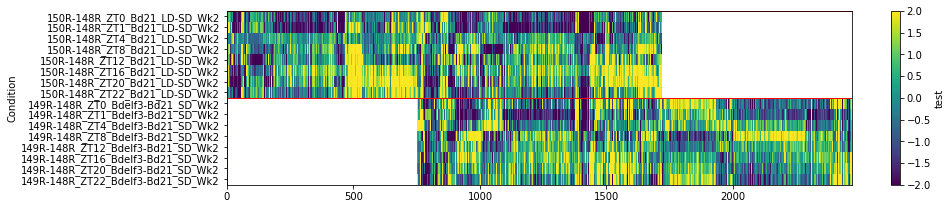

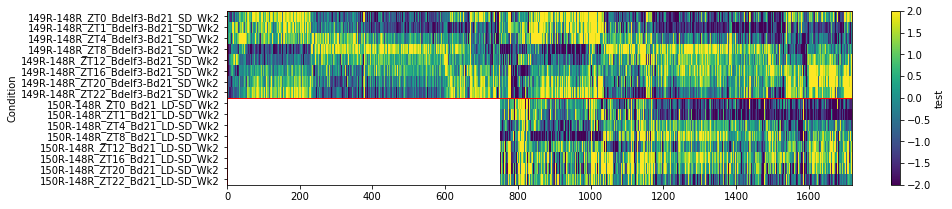

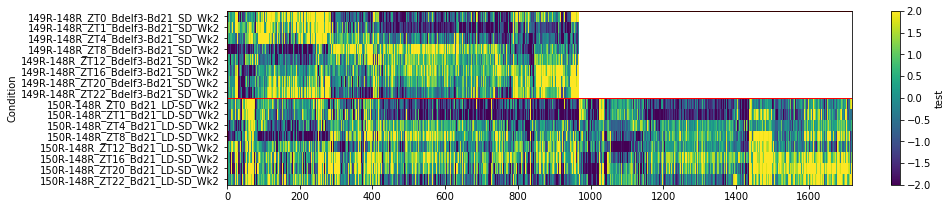

In [167]:
import util;reload(util)
import countMatrix; reload(countMatrix)
countMatrix = util.ctMat.countMatrix
mergeCountMatrix = util.ctMat.mergeCountMatrix
# import countMatrix; reload(countMatrix)
# from countMatrix import countMatrix
# from countMatrix import *

fname = 'Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DDGMM_nClu=30_maxIt=250.npy'
fname = 'Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DDGMM_nClu=30_maxIt=250.npy'
dd1 = countMatrix.from_npy(fname)
fname = 'Clust/round1/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
dd2 = countMatrix.from_npy(fname)
# mergeCountMatrix(fname,dd1)

dout = util.countMatrix.mergeCountMatrix(
    dd1='Clust/round1/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         )
im = dout.heatmap()


mergeCountMatrix(dd1,dd2,how='left').heatmap()
mergeCountMatrix(dd1,dd2,how='right').heatmap()
# import matplotlib.pyplot as plt
# plt.show(im.figure)

# print dout.condCount()

Union:2470, Shared:968


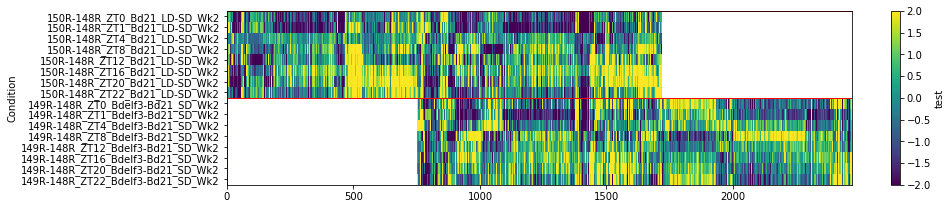

In [146]:
import util;reload(util)
import countMatrix; reload(countMatrix)
countMatrix = util.ctMat.countMatrix
mergeCountMatrix = util.ctMat.mergeCountMatrix
# import countMatrix; reload(countMatrix)
# from countMatrix import countMatrix
# from countMatrix import *

fname = 'Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DDGMM_nClu=30_maxIt=250.npy'
fname = 'Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DDGMM_nClu=30_maxIt=250.npy'
dd1 = countMatrix.from_npy(fname)
fname = 'Clust/round1/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
dd2 = countMatrix.from_npy(fname)
# mergeCountMatrix(fname,dd1)

dout = util.countMatrix.mergeCountMatrix(dd1='Clust/round1/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         )
im = dout.heatmap()
import matplotlib.pyplot as plt
plt.show(im.figure)

# print dout.condCount()

Union:2470, Shared:968
Union:5901, Shared:2693
Union:11004, Shared:6182
Union:17186, Shared:17186


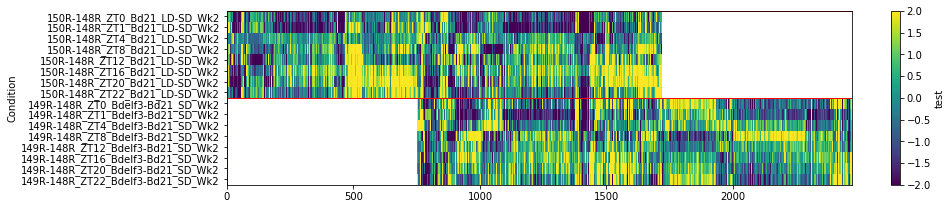

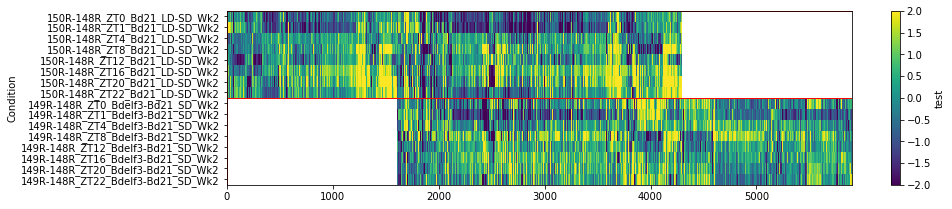

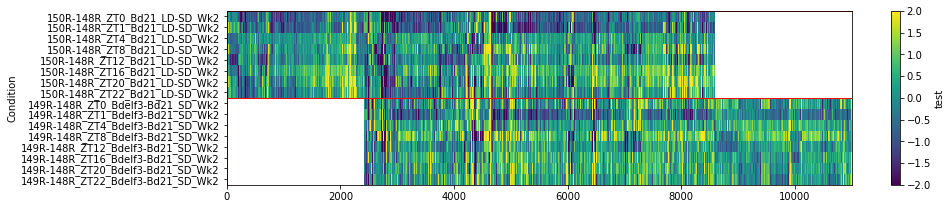

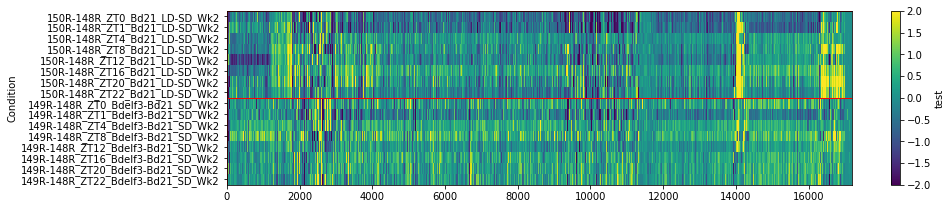

In [176]:
lst = []
common = {'how':'left'}
common = {'how':'outer'}
dd1 = countMatrix.from_npy(fname='Clust/round1/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',)
dout = mergeCountMatrix(
    dd1,
          dd2 ='Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         ,**common)
lst += [ dout ]


dout = mergeCountMatrix(dd1='Clust/round2/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=75_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round2/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=75_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         ,**common)
lst += [ dout ]

dout = mergeCountMatrix(dd1='Clust/round3/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=50_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round3/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=50_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         ,**common)
lst += [ dout ]

dout = mergeCountMatrix(dd1='Clust/round4/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round4/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         ,**common)

lst += [ dout ]
for dout in lst:
    dout.heatmap()

In [169]:
import pandas as pd
fnames =! ls MatPrep/Bd_annotated_*.pk
fnames
df = pd.DataFrame()
for fname in fnames:
    dfc = pd.read_pickle(fname)
    df = pd.concat([df,dfc],axis=1)
countRef = df
#     break

In [177]:
for dout in lst:
    dout.fillNA_withRef(countRef)
    

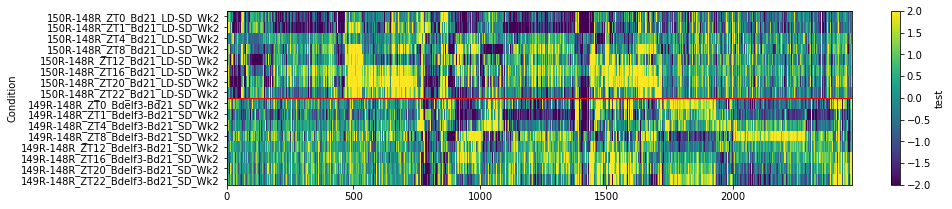

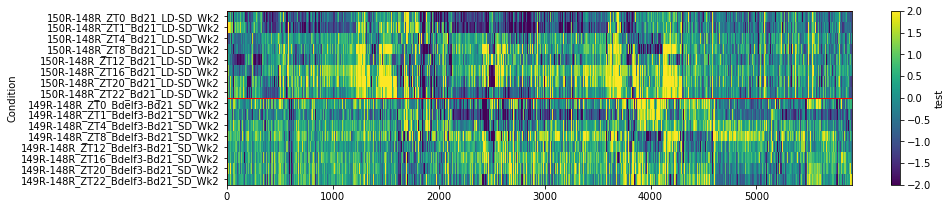

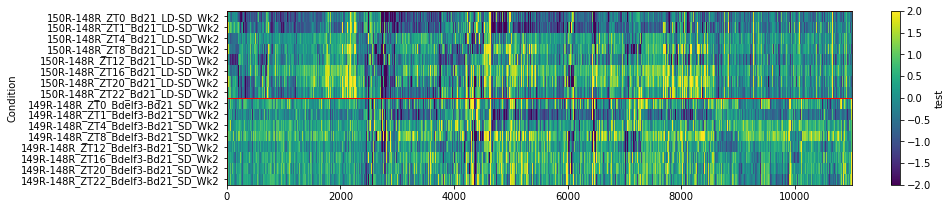

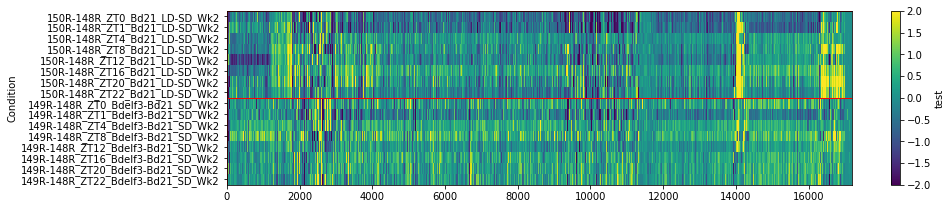

In [178]:
for dout in lst:
    dout.heatmap()

Union:11004, Shared:6182


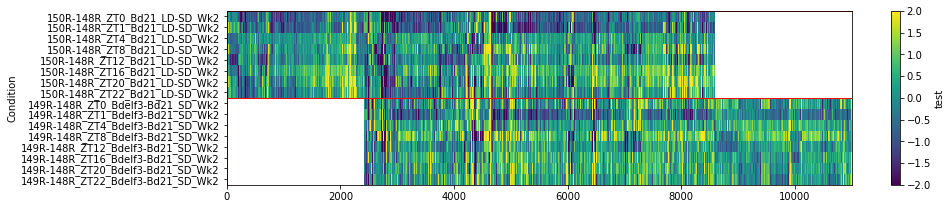

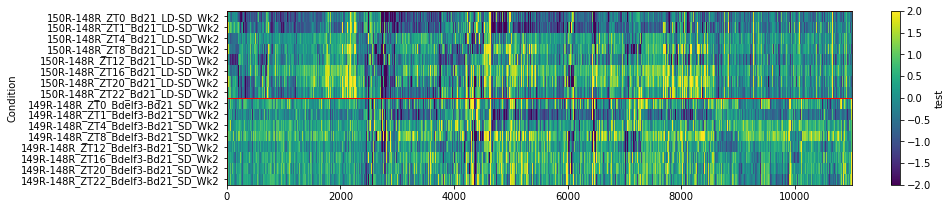

In [37]:
# reload(pyutil)

dout = mergeCountMatrix(dd1='Clust/round3/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=50_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round3/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=50_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         )
dout.heatmap()
dout.fillNA_withRef(countRef)
dout.heatmap()

In [171]:
reload(util)
util.qc_ModelDict(lst[-1],cluMax=2)

[ALI] /home/feng/envs/bulkrna / Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250:Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250
[8, 8]


In [446]:
reload(util)
util.qc_ModelDict(lst[0])

[ALI] /home/feng/envs/bulkrna / Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250:Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250
[8, 8]
(2470, 16) (2470,)


In [39]:
%matplotlib agg

UsageError: Invalid GUI request u'agg', valid ones are:['osx', 'widget', 'qt5', 'qt', 'nbagg', 'qt4', 'gtk', None, 'gtk3', 'notebook', 'tk', 'ipympl', 'inline', 'asyncio', 'wx']


In [172]:
%%time
for dout in lst:
    util.qc_ModelDict(dout)

[ALI] /home/feng/envs/bulkrna / Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250:Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250
[8, 8]
[ALI] /home/feng/envs/bulkrna / Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=75_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250:Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=75_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250
[8, 8]
[ALI] /home/feng/envs/bulkrna / Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=50_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250:Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=50_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250
[8, 8]
[ALI] /home/feng/envs/bulkrna / Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250:Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250
[8, 8]
CPU times: user 2min 30s, sys: 57.6 s, total: 3min 27s
Wall time: 2min 15s


Union:2470, Shared:968
0 8 2470
8 16 2470
Union:2712, Shared:726
0 8 2712
8 14 2712


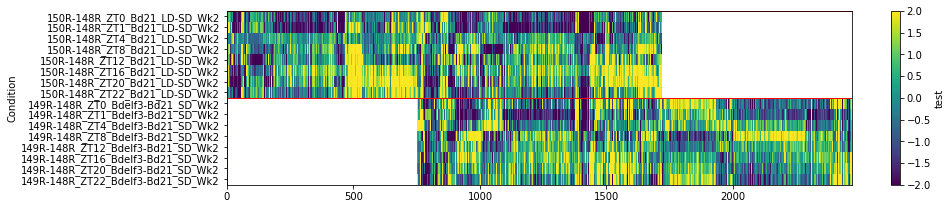

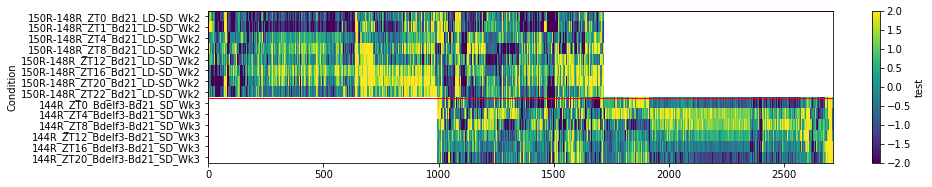

In [24]:

mergeCountMatrix(dd1='Clust/round1/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         ).heatmap()

mergeCountMatrix(dd1='Clust/round1/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round1/Bd_annotated_WK3_SD_elf3KO-WT_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         ).heatmap()

Union:2712, Shared:726


Union:2840, Shared:598
0 8 2840
8 11 2840


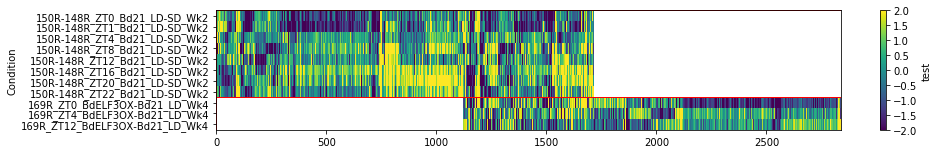

In [25]:
mergeCountMatrix(dd1='Clust/round1/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy',
          dd2 ='Clust/round1/Bd_annotated_WK4_LD_BdELF3OX-WT_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy'
         ).heatmap()

149R-148R_ZT0_Bdelf3-Bd21_SD_Wk2
149R-148R_ZT1_Bdelf3-Bd21_SD_Wk2
149R-148R_ZT4_Bdelf3-Bd21_SD_Wk2
149R-148R_ZT8_Bdelf3-Bd21_SD_Wk2
149R-148R_ZT12_Bdelf3-Bd21_SD_Wk2
149R-148R_ZT16_Bdelf3-Bd21_SD_Wk2
149R-148R_ZT20_Bdelf3-Bd21_SD_Wk2
149R-148R_ZT22_Bdelf3-Bd21_SD_Wk2


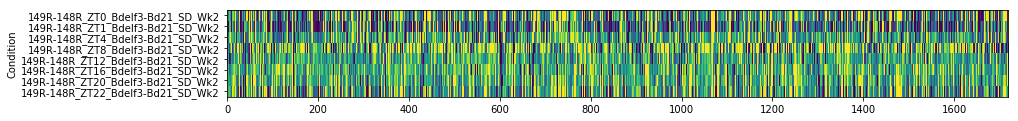

In [32]:
# %matplotlib agg
%matplotlib inline
# pyutil.mpl.use('Agg')
fname = 'Clust/round1/Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=90_norm=identityNorm_genre=DDGMM_nClu=30_maxIt=250.npy'
dd = np.load(fname).tolist()
dd = countMatrix(**dd)
pyutil.printlines(dd.colName_short())
dd.__dict__
im = dd.heatmap()
plt.show(im.axes.figure)